CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

In [14]:
# use/update following 4 lines if used in google-drive
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#import sys
#sys.path.append("/content/drive/My Drive/Colab Notebooks/w7_assignment_ERA/")

#from model_02 import Net2

CODE BLOCK: 2

In [3]:
# check if CUDA is available
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


CODE BLOCK: 3

In [4]:

# Train data transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# load data sets for training and testing
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms) # flag


100%|██████████| 9912422/9912422 [00:00<00:00, 184356509.21it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 97690075.66it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 218788085.94it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20911667.14it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 4

In [5]:
# batch size is the number of samples processed before the model is updated
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 5

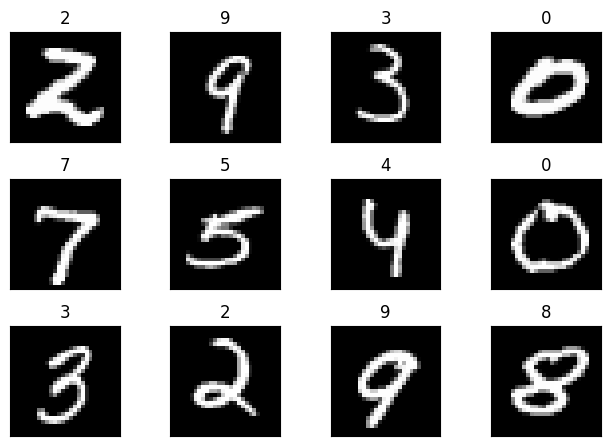

In [6]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 6

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}


def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 7

In [9]:
# model.py

import torch.nn as nn
import torch.nn.functional as F

size1 = 8
size2 = 12
size3 = 16

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, size1, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(size1),
            nn.Conv2d(size1, size1, 3, stride=1, padding=1),
            #
            nn.ReLU(),
            nn.BatchNorm2d(size1),
            nn.Conv2d(size1, size1, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(size1),
            nn.MaxPool2d(2, 2),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(size1, size2, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(size2),
            nn.Conv2d(size2, size2, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(size2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(size2, size3, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(size3),
            nn.MaxPool2d(2, 2),
        )


        self.fc = nn.Sequential(
            nn.Linear(144, 10)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        x = F.log_softmax(x, dim=1)
        return x

from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
#
criterion = nn.CrossEntropyLoss()
num_epochs = 15


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             584
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
            Conv2d-7            [-1, 8, 28, 28]             584
              ReLU-8            [-1, 8, 28, 28]               0
       BatchNorm2d-9            [-1, 8, 28, 28]              16
        MaxPool2d-10            [-1, 8, 14, 14]               0
           Conv2d-11           [-1, 12, 14, 14]             876
             ReLU-12           [-1, 12, 14, 14]               0
      BatchNorm2d-13           [-1, 12, 14, 14]              24
           Conv2d-14           [-1, 12,

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


**CODE** BLOCK: 8

In [10]:

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.0632 Batch_id=117 Accuracy=89.24: 100%|██████████| 118/118 [00:11<00:00,  9.96it/s]


Test set: Average loss: 0.0002, Accuracy: 9753/10000 (97.53%)

Epoch 2


Train: Loss=0.1379 Batch_id=117 Accuracy=97.77: 100%|██████████| 118/118 [00:11<00:00, 10.25it/s]


Test set: Average loss: 0.0001, Accuracy: 9811/10000 (98.11%)

Epoch 3


Train: Loss=0.0636 Batch_id=117 Accuracy=98.41: 100%|██████████| 118/118 [00:11<00:00, 10.00it/s]


Test set: Average loss: 0.0001, Accuracy: 9838/10000 (98.38%)

Epoch 4


Train: Loss=0.0206 Batch_id=117 Accuracy=98.71: 100%|██████████| 118/118 [00:11<00:00, 10.06it/s]


Test set: Average loss: 0.0001, Accuracy: 9879/10000 (98.79%)

Epoch 5


Train: Loss=0.0181 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:12<00:00,  9.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9886/10000 (98.86%)

Epoch 6


Train: Loss=0.0079 Batch_id=117 Accuracy=99.03: 100%|██████████| 118/118 [00:11<00:00, 10.04it/s]


Test set: Average loss: 0.0001, Accuracy: 9892/10000 (98.92%)

Epoch 7


Train: Loss=0.0387 Batch_id=117 Accuracy=99.17: 100%|██████████| 118/118 [00:11<00:00,  9.97it/s]


Test set: Average loss: 0.0001, Accuracy: 9897/10000 (98.97%)

Epoch 8


Train: Loss=0.0106 Batch_id=117 Accuracy=99.25: 100%|██████████| 118/118 [00:12<00:00,  9.72it/s]


Test set: Average loss: 0.0001, Accuracy: 9894/10000 (98.94%)

Epoch 9


Train: Loss=0.0330 Batch_id=117 Accuracy=99.36: 100%|██████████| 118/118 [00:11<00:00, 10.19it/s]


Test set: Average loss: 0.0001, Accuracy: 9893/10000 (98.93%)

Epoch 10


Train: Loss=0.0072 Batch_id=117 Accuracy=99.42: 100%|██████████| 118/118 [00:12<00:00,  9.41it/s]


Test set: Average loss: 0.0001, Accuracy: 9894/10000 (98.94%)

Epoch 11


Train: Loss=0.0017 Batch_id=117 Accuracy=99.50: 100%|██████████| 118/118 [00:12<00:00,  9.55it/s]


Test set: Average loss: 0.0001, Accuracy: 9906/10000 (99.06%)

Epoch 12


Train: Loss=0.0311 Batch_id=117 Accuracy=99.52: 100%|██████████| 118/118 [00:12<00:00,  9.16it/s]


Test set: Average loss: 0.0001, Accuracy: 9894/10000 (98.94%)

Epoch 13


Train: Loss=0.0068 Batch_id=117 Accuracy=99.61: 100%|██████████| 118/118 [00:12<00:00,  9.23it/s]


Test set: Average loss: 0.0001, Accuracy: 9900/10000 (99.00%)

Epoch 14


Train: Loss=0.0426 Batch_id=117 Accuracy=99.62: 100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


Test set: Average loss: 0.0001, Accuracy: 9897/10000 (98.97%)

Epoch 15


Train: Loss=0.0262 Batch_id=117 Accuracy=99.68: 100%|██████████| 118/118 [00:11<00:00,  9.89it/s]


Test set: Average loss: 0.0001, Accuracy: 9883/10000 (98.83%)



**CODE** BLOCK: 9

Text(0.5, 1.0, 'Test Accuracy')

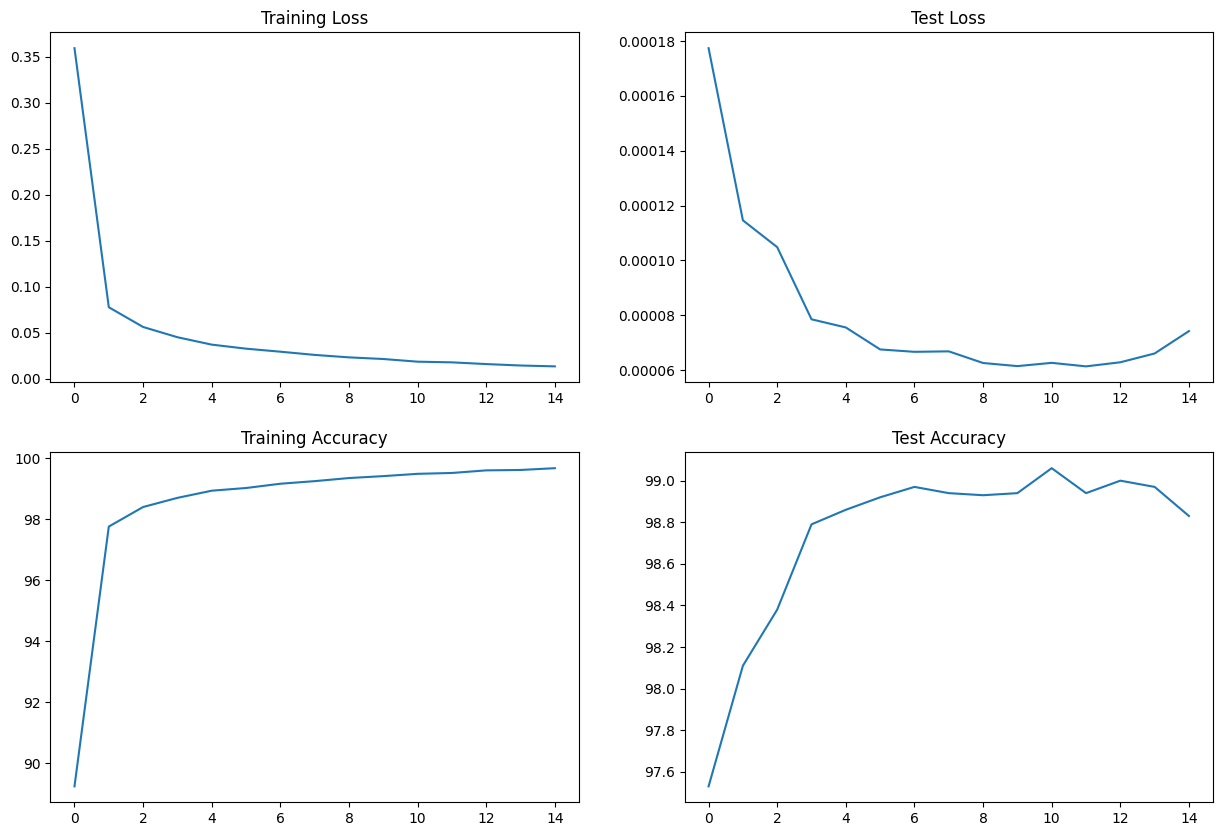

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [12]:

min_train_loss_epoch = train_losses.index(min(train_losses)) + 1
min_test_loss_epoch = test_losses.index(min(test_losses)) + 1
best_train_acc_epoch = train_acc.index(max(train_acc)) + 1
best_test_acc_epoch = test_acc.index(max(test_acc)) + 1

print("Minimum training loss = {:.9f}% at epoch {}".format(min(train_losses), min_train_loss_epoch))
print("Minimum testing loss = {:.9f}% at epoch {}".format(min(test_losses), min_test_loss_epoch))
print("Best training accuracy = {:.2f}% at epoch {}".format(max(train_acc), best_train_acc_epoch))
print("Best testing accuracy = {:.2f}% at epoch {}".format(max(test_acc), best_test_acc_epoch))


Minimum training loss = 0.013202868% at epoch 15
Minimum testing loss = 0.000061376% at epoch 12
Best training accuracy = 99.68% at epoch 15
Best testing accuracy = 99.06% at epoch 11


##**Target**

- Make model very lighter with less than 8k parameters
- Use batch normalization
- Use fully connected layer
- Use max pooling at appropriate places

##**Results:**

- Total parameters: 6,754
- Best train accuracy: 99.68% at epoch 15
- Best test accuracy: 99.06% at epoch 11

# **Analysis**

- Decent accuracy with very few parameters
- The model is still overfitted
- Regularization can be useful to reduce overfitting
- Image processing with random nature can be useful to increase test accuracy